Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Selected images for feature matching: ['c3ab82ff-798a-4222-b091-10d81433050e.JPG', 'de727128-7b3f-45b0-80e9-ec95f5da01d8.JPG', '6535079d-ec8e-4184-a898-bd91ac08a14e.JPG', '8c8f067f-374e-4164-b227-50a78c3f72e0.JPG']


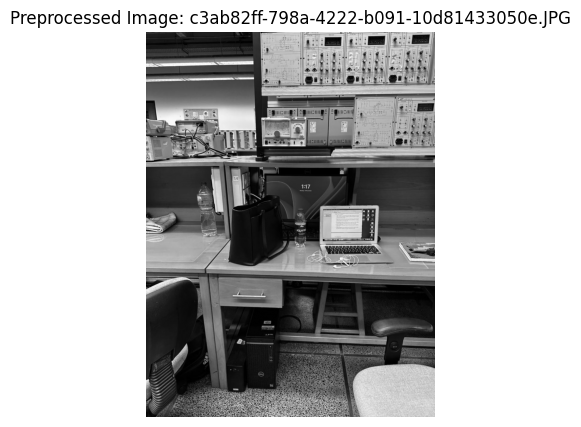

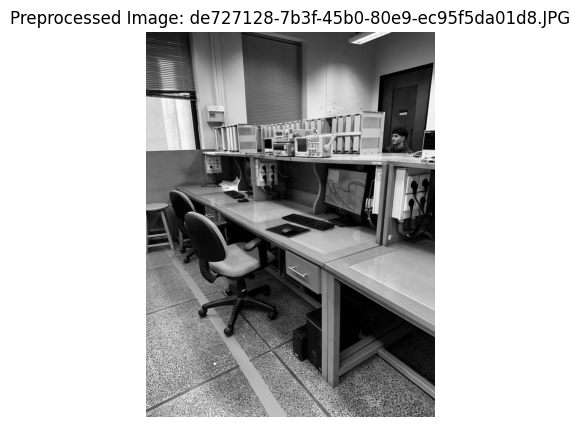

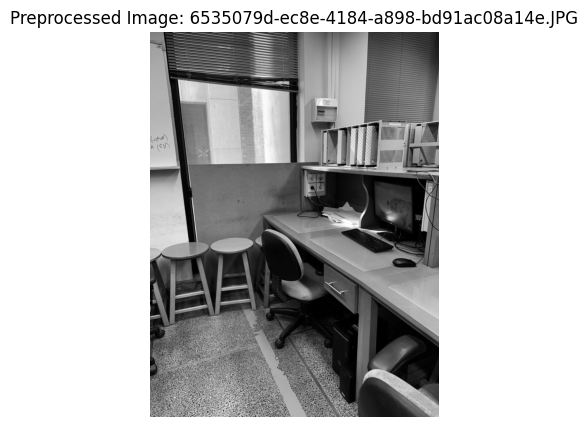

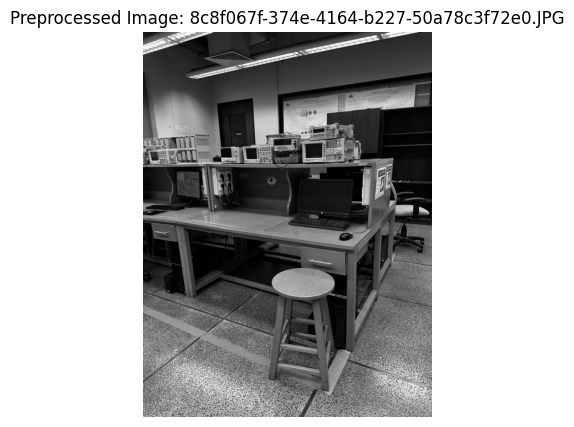

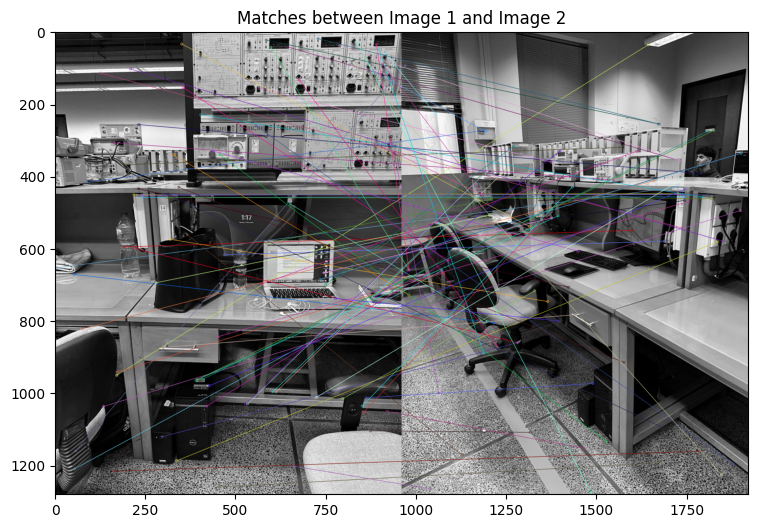

Matched image saved to /content/drive/My Drive/Photo/matched_image_1_2.jpg


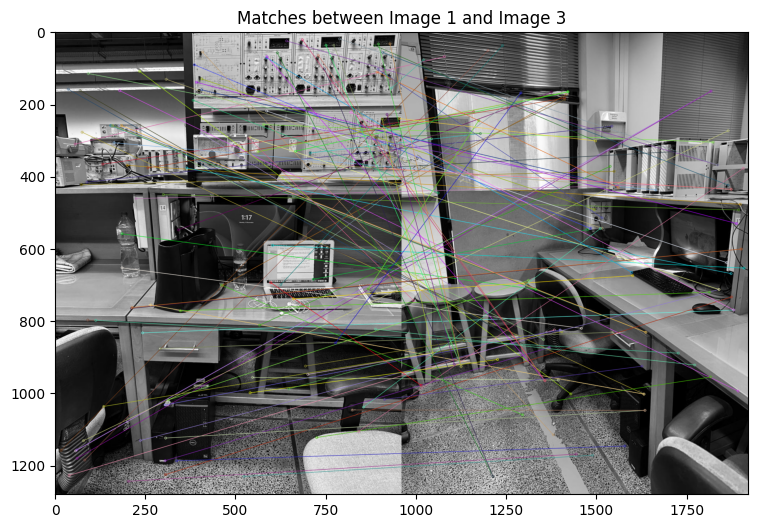

Matched image saved to /content/drive/My Drive/Photo/matched_image_1_3.jpg


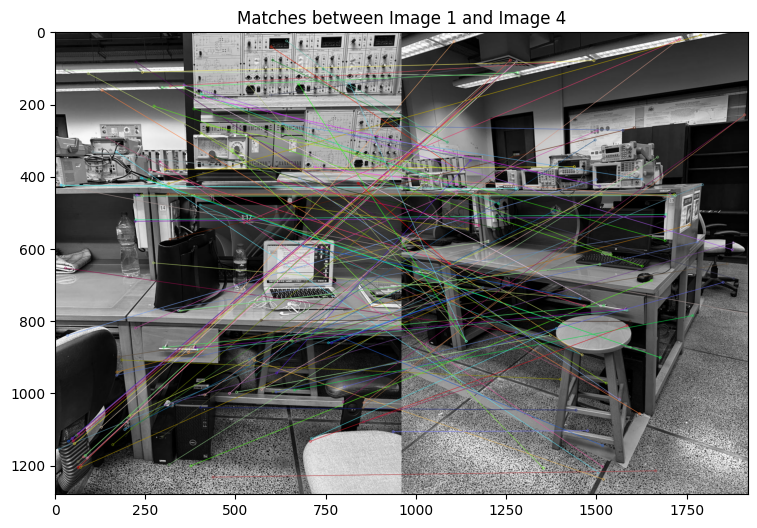

Matched image saved to /content/drive/My Drive/Photo/matched_image_1_4.jpg


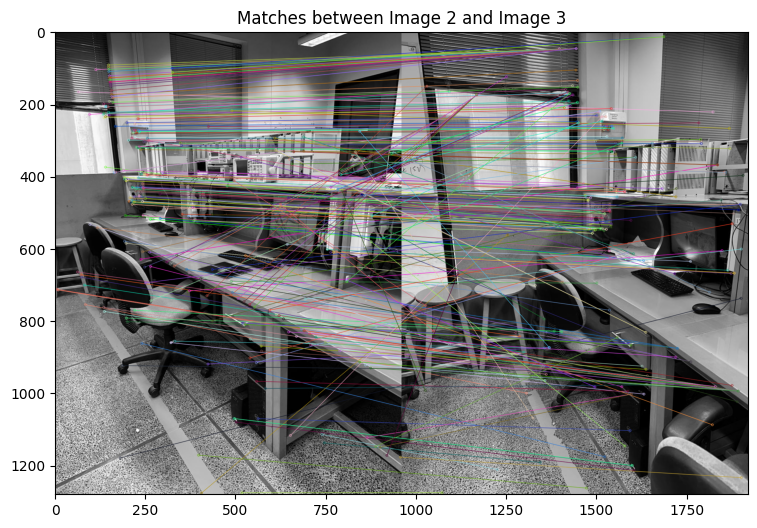

Matched image saved to /content/drive/My Drive/Photo/matched_image_2_3.jpg


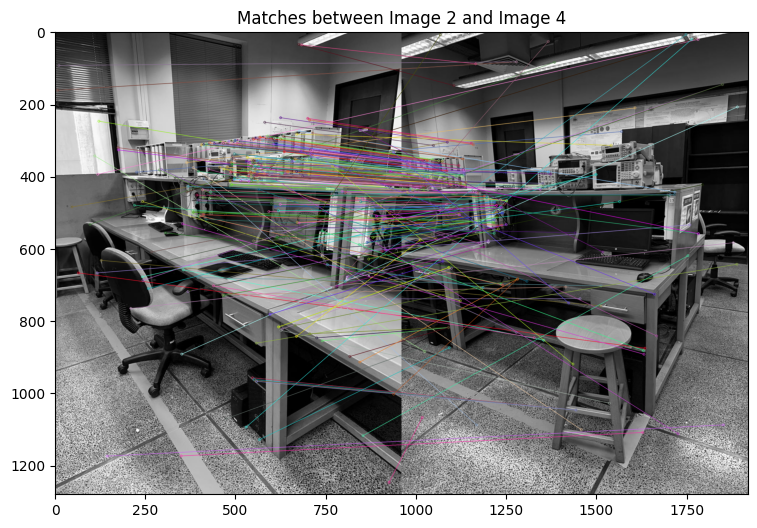

Matched image saved to /content/drive/My Drive/Photo/matched_image_2_4.jpg


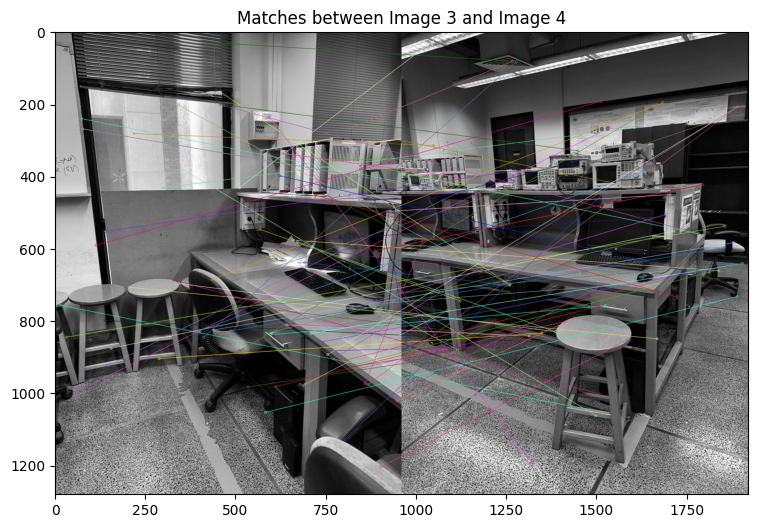

Matched image saved to /content/drive/My Drive/Photo/matched_image_3_4.jpg


In [7]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
image_folder = '/content/drive/My Drive/Photo/Dataset'

# generate image file names dynamically for .JPEG and .JPG files
image_files = [f for f in os.listdir(image_folder) if f.endswith('.JPEG') or f.endswith('.JPG')]

# filter out any files that don't exist
image_files = [f for f in image_files if os.path.exists(os.path.join(image_folder, f))]

# randomly select 4 images from the available files
if len(image_files) < 4:
    print(f"Warning: Only {len(image_files)} images are available, using all of them.")
    selected_images = image_files  # Use all available images if fewer than 4
else:
    selected_images = random.sample(image_files, 4)

print(f"Selected images for feature matching: {selected_images}")

# preprocess and display the selected images
for img_file in selected_images:
    # load image in grayscale
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # optional preprocessing to resize images to a fixed size
    #image_resized = cv2.resize(image, (500, 500))

    # optional normalization to normalize pixel values to [0, 1] range
    #image_normalized = image_resized / 255.0

    # display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title(f'Preprocessed Image: {img_file}')
    plt.axis('off')
    plt.show()

# initialized SIFT detector
sift = cv2.SIFT_create()

# initialized FLANN based matcher
index_params = dict(algorithm=1, trees=10)  # randomized kd-tree algorithm
search_params = dict(checks=50)  # number of times the tree checkedrecursively
flann = cv2.FlannBasedMatcher(index_params, search_params)

# store keypoints and descriptors
keypoints_list = []
descriptors_list = []
images = []

# load and compute keypoints and descriptors for the selected images
for image_file in selected_images:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)
    images.append(image)

# match features across all pairs of selected images
good_matches_all = []

for i in range(len(images)):
    for j in range(i+1, len(images)):
        # get keypoints and descriptors for the pair of images
        # kp1: list of keypoints (locations, scale, orientation)
        # des1: array of 128-dimensional vectors representing local features
        kp1, des1 = keypoints_list[i], descriptors_list[i]
        kp2, des2 = keypoints_list[j], descriptors_list[j]

        # FLANN based matcher
        matches = flann.knnMatch(des1, des2, k=2)
        # apply Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        # store the good matches
        good_matches_all.append((i, j, good_matches, kp1, kp2))

# plot matched features for each pair of selected images
for i, j, good_matches, kp1, kp2 in good_matches_all:
    matched_image = cv2.drawMatches(images[i], kp1, images[j], kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 6))
    plt.imshow(matched_image)
    plt.title(f'Matches between Image {i+1} and Image {j+1}')
    plt.show()

    # save the matched images
    save_path = f'/content/drive/My Drive/Photo/matched_image_{i+1}_{j+1}.jpg'
    cv2.imwrite(save_path, matched_image)
    print(f'Matched image saved to {save_path}')
